In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os, random
from pathlib import Path
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
import joblib
np.random.seed(0)
sns.set_style("darkgrid")

orig = pd.read_parquet("/Users/lselig/selig-fa/finance/.data/evs_ratios.parquet")
print(orig.shape)
for c in orig:
    print(c)
features = pd.read_parquet("/Users/lselig/selig-fa/finance/.data/evs_ratios_preprocessed.parquet")
features = features.drop(columns = ["marketCapitalization", "enterpriseValue"])
meta_cols = ["stockPrice", "date", "year",
             "symbol", "quarter", "cik", "isEtf", "isActivelyTrading", "isFund", "country", "ipoDate"]


holdout = features[features.year == 2022]
features = features[features.year != 2022]

holdout_meta = holdout[meta_cols]
features_meta = features[meta_cols]

labels_holdout = np.log10(holdout.stockPrice.values)
labels = np.log10(features.stockPrice.values)

holdout = holdout.drop(columns = meta_cols)
features = features.drop(columns = meta_cols)




In [ ]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size = 0.99)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
y_train = y_train.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(X_train)
scaler_y.fit(y_train)

X_train = scaler_X.transform(X_train)
y_train = scaler_y.transform(y_train)
X_test = scaler_X.transform(X_test)

In [ ]:
model = Ridge()
cv = 10
alphas_ = [10 ** i for i in range(-5, 5)]
print(alphas_)
param_grid = {"alpha": alphas_}
search = GridSearchCV(model, param_grid, scoring = "r2", n_jobs = -1, cv=cv, verbose = 3)
result = search.fit(X_train, y_train)
alpha_opt = search.best_params_["alpha"]

print(f"{alpha_opt = }")
print(f"{result.cv_results_['mean_test_score']}")

In [ ]:

# model = RandomForestRegressor()
# cv = 10
# param_grid = {"criterion": ["squared_error", "absolute_error"],
#               "max_depth": [5, 6, 7, 8, 9, 10],
#               "n_estimators": [100, 200, 500]
#               }
# reg = RandomizedSearchCV(model, param_grid, scoring = "r2", n_jobs = -1, cv = cv, verbose = 10)
# search = reg.fit(X_train, y_train.ravel())
# print(search.best_params_)
# joblib.dump(search, "/Users/lselig/selig-fa/finance/.data/random_forest.pkl")
# # search = joblib.load("/Users/lselig/selig-fa/finance/.data/ridge.pkl")

In [ ]:
model = Ridge(alpha = 1)
model = model.fit(X_train, y_train)
# joblib.dump(model, "/Users/lselig/selig-fa/finance/.data/ridge.pkl")
# model = joblib.load("/Users/lselig/selig-fa/finance/.data/ridge.pkl")
pred = model.predict(X_test)
pred = scaler_y.inverse_transform(pred).ravel()
true = y_test

pred = 10 ** pred
true = 10 ** true
print(model.score(X_test, scaler_y.transform(y_test.reshape(-1, 1))))
print(model.coef_)
print(list(features))
# print(pred)
# print(true)
print(np.corrcoef(pred, true)[0, 1])


plt.hist2d(pred, true, bins = 450)
plt.xlim(0, 100)
plt.ylim(0, 100)
# plt.scatter(pred, true)
plt.show()


In [ ]:
pred = model.predict(scaler_X.transform(holdout))
pred = scaler_y.inverse_transform(pred).ravel()
pred = 10 ** pred

In [ ]:
from collections import namedtuple
from operator import attrgetter
Valuation = namedtuple("Valuation", 'true, pred, multi, symbol, period, date')
vs = []

diff = pred - 10 ** labels_holdout
plt.plot(diff)
plt.title("Higher y = Buy me")
plt.ylabel("Pred - True")
plt.show()
for i, d in enumerate(diff):
    relevance = pred[i] / (10 ** labels_holdout[i])
    if(holdout_meta.iloc[i].symbol == "SIX"):
        print(pred[i])
    if(relevance > 1.75):
        v = Valuation(10 ** labels_holdout[i],
                      pred[i],
                      relevance,
                      holdout_meta.iloc[i].symbol,
                      holdout_meta.iloc[i].quarter,
                      holdout_meta.iloc[i].date)
        vs.append(v)
        # print(f"{d = }, {relevance = }, {pred[i] = }, {10 ** labels_holdout[i] = }\n, {holdout_meta.iloc[i].to_string()}\n\n")
vs.sort(key = attrgetter("multi"), reverse = True)
# for v in vs:
#     print(v)
#     print("-" * 100)
# print(vs)

 Assumptions of linear regression
 1) Independence of errors
 2) Correlation between x and y
 3) No high multicollinearity amongst features
 4) Constant variance
 5) Normality of residuals

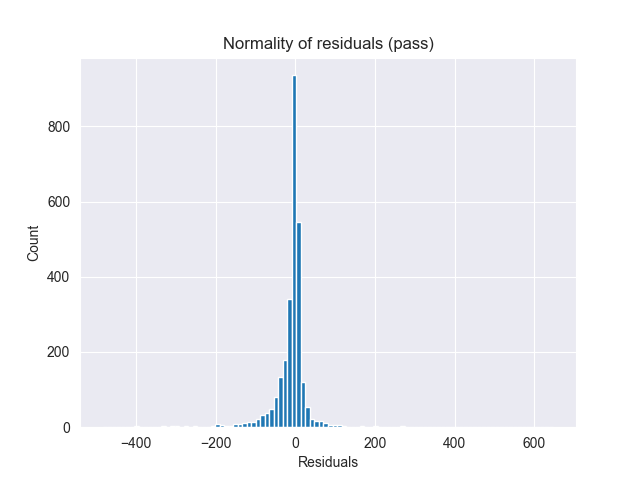

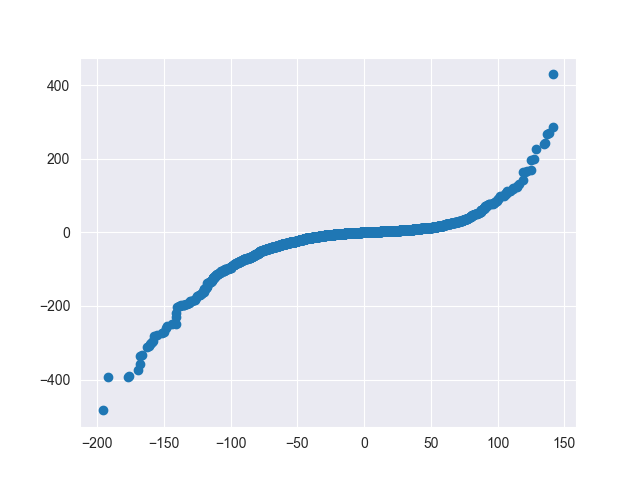

In [181]:
plt.hist(diff, bins = 100)
plt.title("Normality of residuals (pass)")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.show()
plt.close()

mu = np.nanmean(diff)
std = np.nanstd(diff)
n_obs = len(diff)
rnorm = np.random.normal(scale = std, loc = mu, size = n_obs)
rnorm_quantiles = [np.quantile(rnorm, (k)/n_obs) for k in range(n_obs)]
obs_quantiles = [np.quantile(diff, (k)/n_obs) for k in range(n_obs)]

plt.scatter(rnorm_quantiles, obs_quantiles)
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()

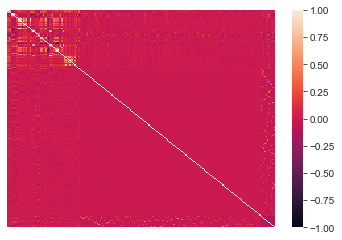

In [167]:
corr = features.corr()
sns.heatmap(corr, annot = False, xticklabels = False, yticklabels = False)

plt.show()

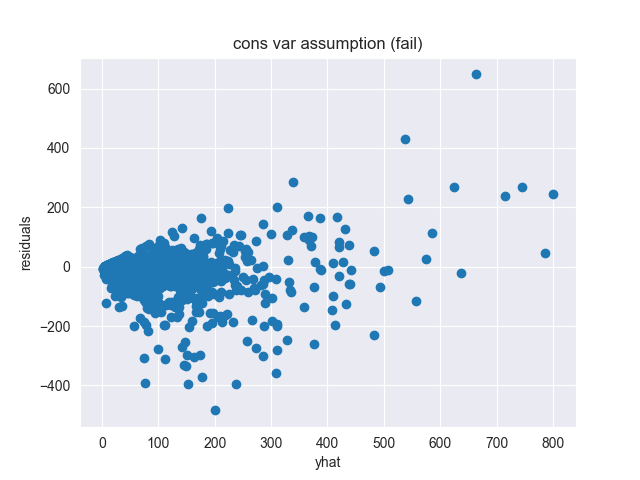

In [182]:
%matplotlib widget
plt.scatter(pred, diff)
plt.xlabel("yhat")
plt.ylabel("residuals")
plt.title("cons var assumption (fail)")
plt.show()

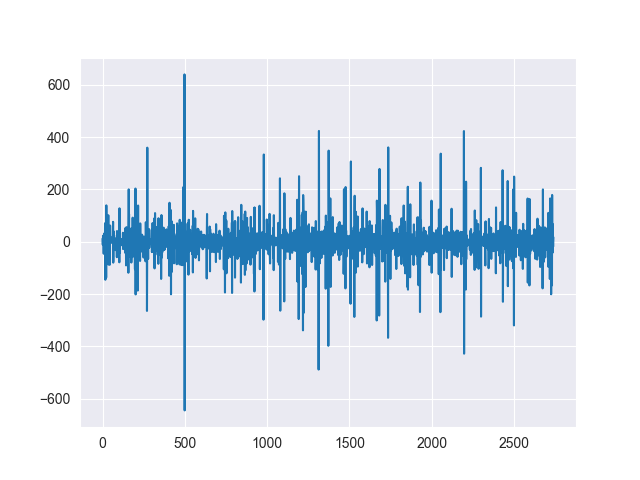

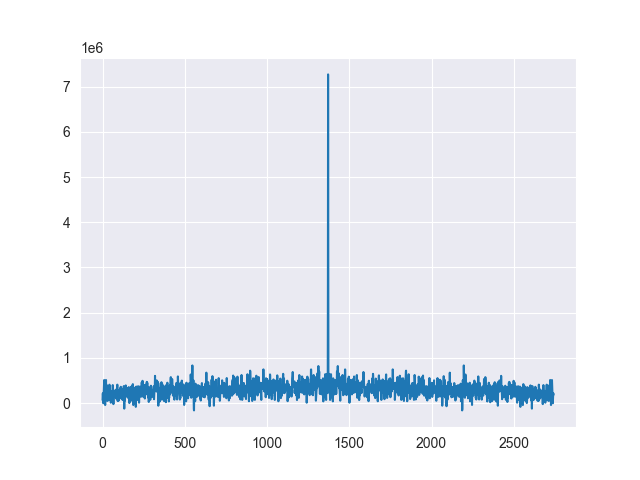

In [188]:
plt.close()
plt.plot(np.diff(diff))
plt.show()


def scale_me(x):
    l = -1
    h = 1
    return ((x - np.nanmin(x)) * (h-l)  / (np.nanmax(x) - np.nanmin(x))) + l
acr = np.correlate(diff, diff, mode='same')
# acr = scale_me(acr)
plt.close()
plt.plot(acr)
plt.show()